#Mount and imports

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [3]:
!nvidia-smi

Sat Oct 30 16:16:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install transformers==4.2.1
!pip install farasapy
!pip install pyarabic
!pip install sentencepiece
!git clone https://github.com/aub-mind/arabert
!git clone https://github.com/iR00i/JUST-Arabic-Propaganda.git

fatal: destination path 'arabert' already exists and is not an empty directory.
fatal: destination path 'JUST-Arabic-Propaganda' already exists and is not an empty directory.


In [5]:
!pip install -U scikit-learn

In [6]:
import pandas as pd
import numpy as np
import re

#Support Vector Machine

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score

In [ ]:
path = r'/content/JUST-Arabic-Propaganda/data/Translated Data/'
train = pd.read_csv(path+'train.csv')
valid = pd.read_csv(path+'valid.csv')
test = pd.read_csv(path+'test.csv')

In [ ]:
def SVM_Tfidf(train, test):
  train = MapLabels(train)
  test = MapLabels(test)

  Tfidf_vect = TfidfVectorizer()
  Tfidf_vect.fit(train['Arabic'])

  Train_X_Tfidf = Tfidf_vect.transform(train['Arabic'])
  Test_X_Tfidf = Tfidf_vect.transform(test['Arabic'])

  Train_Y = np.array(train['target'].tolist())
  Test_Y = np.array(test['target'].tolist())
  # Classifier - Algorithm - SVM
  # fit the training dataset on the classifier
  SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', )
  SVM.fit(Train_X_Tfidf, Train_Y)
  # predict the labels on test dataset
  predictions_SVM = SVM.predict(Test_X_Tfidf)
  # Use accuracy_score function to get the accuracy
  f1_micro = metrics.f1_score(Test_Y, predictions_SVM,average='micro')
  print("SVM Accuracy Score: ",accuracy_score(predictions_SVM, Test_Y))
  print("SVM F1-Micro Score: ",f1_micro)

SVM Accuracy Score:  0.5680555555555555
SVM F1-Micro Score:  0.5680555555555555


In [ ]:
SVM_Tfidf(train, test)

#LSTM

In [9]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
import json

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

##Utility

In [10]:
def MapLabels(df):
  """
  Function to preprocess data.
  Creates a one-hot-encoded version of the labels. 
  """
  onehot_col = []
  map = {
      'Appeal_to_Authority':0,
      'Appeal_to_fear-prejudice':1,
      'Bandwagon,Reductio_ad_hitlerum':2,
      'Black-and-White_Fallacy':3,
      'Causal_Oversimplification':4,
      'Doubt':5,
      'Exaggeration,Minimisation':6,
      'Flag-Waving':7,
      'Loaded_Language':8,
      'Name_Calling,Labeling':9,
      'Repetition':10,
      'Slogans':11,
      'Thought-terminating_Cliches':12,
      'Whataboutism,Straw_Men,Red_Herring':13
  }

  for idx,row in df.iterrows():
    temp = [0] * 14
    label = row['label']
    temp[map[label]] = 1
    onehot_col.append(temp)
  
  df['onehot'] = onehot_col
  return df

In [19]:
def train_fn(data_loader, model, optimizer, device):
  model.train()
  loss_function = nn.BCEWithLogitsLoss()
  for i, (inputs, targets) in tqdm(enumerate(data_loader), total=len(data_loader)):
    # Predict/Forward Pass
    # inputs: x_batch of shape (train_batch_size, num_labels)
    # targets: y_batch of shape (train_batch_size, num_labels)
    optimizer.zero_grad()

    outputs = model(inputs)

    targets = targets.float()
    loss = loss_function(outputs, targets)

    loss.backward()
    optimizer.step()

def eval_fn(data_loader, model, device):
  model.eval()
  fin_targets = []
  fin_outputs = []
  with torch.no_grad():
    for i, (inputs, targets) in tqdm(enumerate(data_loader), total=len(data_loader)):
      outputs = model(inputs)

      targets = targets.float()

      fin_targets.extend(targets.cpu().detach().numpy().tolist())
      fin_outputs.extend(F.softmax(outputs, dim = 1).cpu().detach().numpy().tolist())
  
  return fin_outputs, fin_targets

In [12]:
def loss_fn(outputs, targets):
  """ 
  Loss function to claculate loss. Loss measure used is the Binary-Cross-
  Entropy.
  """
  return nn.BCEWithLogitsLoss()(outputs, targets)

In [13]:
def Train(train, valid, text_col_name):

  train = MapLabels(train)
  valid = MapLabels(valid)

  train_X = train[text_col_name]
  test_X = valid[text_col_name]
  train_y = train['label']
  test_y = valid['label']

  ## Tokenize the sentences
  tokenizer = Tokenizer(num_words=config['max_features'])
  tokenizer.fit_on_texts(list(train_X))
  train_X = tokenizer.texts_to_sequences(train_X)
  test_X = tokenizer.texts_to_sequences(test_X)

  ## Pad the sentences 
  train_X = pad_sequences(train_X, maxlen=config['maxlen'])
  test_X = pad_sequences(test_X, maxlen=config['maxlen'])

  train_y = train['onehot']
  test_y = valid['onehot']
  # Load train and test in CUDA Memory
  x_train = torch.tensor(train_X, dtype=torch.long).cuda()
  y_train = torch.tensor(train_y, dtype=torch.long).cuda()
  x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
  y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

  # Create Torch datasets
  train = torch.utils.data.TensorDataset(x_train, y_train)
  valid = torch.utils.data.TensorDataset(x_cv, y_cv)

  # Create Data Loaders
  train_loader = DataLoader(train, batch_size=config['train_batch_size'], shuffle=True)
  valid_loader = DataLoader(valid, batch_size=config['valid_batch_size'], shuffle=False)

  device = torch.device(config['device'])

  model = BiLSTM_model(max_features=config['max_features'],
                      embedding_dim=config['embedding_size'],
                      hidden_dim=config['lstm_hidden_dim'],
                      num_layers = config['num_lstm_layers'],
                      lstm_dropout = config['lstm_dropout'])
  model.to(device)

  optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config['learning_rate'])
  loss_function = nn.BCEWithLogitsLoss()

  best_score = 0
  for epoch in range(config['epochs']):
    train_fn(train_loader, model, optimizer, device)
    outputs, targets = eval_fn(valid_loader, model, device)
    outputs = np.array(outputs) >= 0.5

    accuracy = metrics.accuracy_score(targets, outputs)
    f1_micro = metrics.f1_score(targets, outputs,average='micro')
    print(f"<---------------Epoch {epoch+1}--------------->")
    print(f"f1-Micro Score = {f1_micro}")
    print(f"Accuracy Score = {accuracy}")

    if f1_micro > best_score:
      print("Saving model...")
      torch.save(model.state_dict(), config['model_save_path'])
      best_score = f1_micro

  target_names = [
    'Appeal_to_Authority',
    'Appeal_to_fear-prejudice',
    'Bandwagon,Reductio_ad_hitlerum',
    'Black-and-White_Fallacy',
    'Causal_Oversimplification',
    'Doubt',
    'Exaggeration,Minimisation',
    'Flag-Waving',
    'Loaded_Language',
    'Name_Calling,Labeling',
    'Repetition',
    'Slogans',
    'Thought-terminating_Cliches',
    'Whataboutism,Straw_Men,Red_Herring']
  print(metrics.classification_report(targets,outputs,target_names=target_names, zero_division='warn'))

  with open(config['model_args_path'], 'w') as fp:
    json.dump(config, fp)

In [14]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
  """
  Function to print confusion matrix for labels.
  """
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names,
  )

  try:
      heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  axes.set_ylabel('True label')
  axes.set_xlabel('Predicted label')
  axes.set_title(class_label)

##Model Archi

In [15]:
class BiLSTM_model(torch.nn.Module) :
    def __init__(self, max_features, embedding_dim, hidden_dim, num_layers, lstm_dropout) :
        # max_features is the vocabulary size (num of tokens/words).
        super().__init__()
        self.embeddings = nn.Embedding(max_features, embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            batch_first=True,
                            bidirectional=True,
                            num_layers = num_layers,
                            dropout=lstm_dropout)
        self.relu=nn.ReLU()
        self.fc1 = nn.Linear(hidden_dim * 2, 64)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, config['num_classes'])

    def forward(self, input):
        embeddings_out = self.embeddings(input)
        lstm_out, (hidden, cell) = self.lstm(embeddings_out)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        rel = self.relu(hidden)
        dense1 = self.fc1(rel)
        drop = self.dropout(dense1)
        final_out = self.fc2(drop)

        return final_out

##Debugging

In [140]:
train = MapLabels(train)
test = MapLabels(test)

train_X = train['Arabic']
test_X = test['Arabic']
train_y = train['label']
test_y = test['label']

## Tokenize the sentences
tokenizer = Tokenizer(num_words= config['max_features'])
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=config['maxlen'])
test_X = pad_sequences(test_X, maxlen=config['maxlen'])

train_y = train['onehot']
test_y = test['onehot']

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=config['train_batch_size'], shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=config['valid_batch_size'], shuffle=False)

model = BiLSTM_model(max_features=max_features,
                       embedding_dim=512,
                       hidden_dim=64)
model.to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss_function = nn.BCEWithLogitsLoss()

In [61]:
print(f"shape of targets: ({len(targets)}, {len(targets[0])})")
print(f"shape of outputs: ({len(outputs)}, {len(outputs[0])})")

shape of targets: (720, 14)
shape of outputs: (720, 14)


In [227]:
model = BiLSTM_model(max_features=config['max_features'],
                     embedding_dim=config['embedding_size'],
                     hidden_dim=config['lstm_hidden_dim'],
                     num_layers = config['num_lstm_layers'],
                     lstm_dropout = config['lstm_dropout'])
model.to(device)

BiLSTM_model(
  (embeddings): Embedding(120000, 512, padding_idx=0)
  (lstm): LSTM(512, 64, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (relu): ReLU()
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=14, bias=True)
)

In [228]:
for i, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
  # Predict/Forward Pass
  # inputs: x_batch of shape (train_batch_size, num_labels)
  # targets: y_batch of shape (train_batch_size, num_labels)
  inputs.to(device)
  optimizer.zero_grad()
  outputs = model(inputs)
  targets = targets.float()
  loss = loss_function(outputs, targets)
  loss.backward()
  optimizer.step()

  break

  0%|          | 0/180 [00:00<?, ?it/s]

##Config and Training

In [16]:
config = {
    'embedding_size': 512, # how big is each word vector
    'max_features': 120000, # how many unique words to use (i.e num rows in embedding vector)
    'maxlen': 250, # max number of words in a training sample
    'num_classes':14,

    'train_batch_size': 32, # how many train-samples to process per batch
    'valid_batch_size': 16, # how many valid-samples to process per batch

    'epochs': 15, # how many times to iterate over all samples
    'learning_rate': 5e-3,
    
    'lstm_hidden_dim':64,
    'num_lstm_layers':2,
    'lstm_dropout':0.3,

    'device': 'cuda',
    'model_save_path':"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Bilstm_model.bin",
    'model_args_path':"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Bilstm_model.json",
}

In [17]:
path = r'/content/JUST-Arabic-Propaganda/data/Translated Data/'
train = pd.read_csv(path+'train.csv')
valid = pd.read_csv(path+'valid.csv')
test = pd.read_csv(path+'test.csv')

In [20]:
Train(train, valid, 'Arabic')

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.3523404255319149
Accuracy Score = 0.28789986091794156
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.41908325537885877
Accuracy Score = 0.31154381084840055
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.44274809160305345
Accuracy Score = 0.36300417246175243
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.4740740740740741
Accuracy Score = 0.40055632823365783
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.4458015267175572
Accuracy Score = 0.40611961057023643


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.47981721249047976
Accuracy Score = 0.4381084840055633
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.46735905044510384
Accuracy Score = 0.4381084840055633


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.4658753709198813
Accuracy Score = 0.43671766342141866


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Micro Score = 0.4583640383198231
Accuracy Score = 0.4325452016689847


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 10--------------->
f1-Micro Score = 0.45222465353756375
Accuracy Score = 0.43115438108484005


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 11--------------->
f1-Micro Score = 0.46436443791329907
Accuracy Score = 0.43949930458970793


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 12--------------->
f1-Micro Score = 0.4495677233429395
Accuracy Score = 0.4339360222531293


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 13--------------->
f1-Micro Score = 0.4442846872753415
Accuracy Score = 0.4297635605006954


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 14--------------->
f1-Micro Score = 0.44793152639087025
Accuracy Score = 0.43671766342141866


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 15--------------->
f1-Micro Score = 0.4455882352941177
Accuracy Score = 0.42141863699582754
                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.06      0.06      0.06        16
          Appeal_to_fear-prejudice       0.14      0.15      0.14        34
    Bandwagon,Reductio_ad_hitlerum       0.00      0.00      0.00         8
           Black-and-White_Fallacy       1.00      0.08      0.14        13
         Causal_Oversimplification       0.38      0.14      0.20        22
                             Doubt       0.36      0.16      0.22        56
         Exaggeration,Minimisation       0.27      0.38      0.31        53
                       Flag-Waving       0.48      0.32      0.38        31
                   Loaded_Language       0.63      0.58      0.61       245
             Name_Calling,Labeling       0.61      0.46      0.53       124
                        Repetition       0.43    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Evaluation

In [21]:
def Test(train, test, model, text_col_name):
  test = MapLabels(test)
  model.eval()
  device = torch.device(config['device'])
  model.to(device)

  train_X = train[text_col_name]
  test_X = test[text_col_name]
  train_y = train['label']
  test_y = test['label']

  ## Tokenize the sentences
  tokenizer = Tokenizer(num_words=config['max_features'])
  tokenizer.fit_on_texts(list(train_X))

  test_X = tokenizer.texts_to_sequences(test_X)
  ## Pad the sentences 
  test_X = pad_sequences(test_X, maxlen=config['maxlen'])

  test_y = test['onehot']

  x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
  y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

  test = torch.utils.data.TensorDataset(x_cv, y_cv)

  test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

  outputs, targets = eval_fn(test_loader, model, device)
  outputs = np.array(outputs) >= 0.5
  accuracy = metrics.accuracy_score(targets, outputs)
  f1_micro = metrics.f1_score(targets, outputs,average='micro')
  print(f"<---------------Test Set Performance--------------->")
  print(f"f1-Micro Score = {f1_micro}")
  print(f"Accuracy Score = {accuracy}")

  gold_list = targets
  preds_list = outputs

  target_names = [
        'Appeal_to_Authority',
        'Appeal_to_fear-prejudice',
        'Bandwagon,Reductio_ad_hitlerum',
        'Black-and-White_Fallacy',
        'Causal_Oversimplification',
        'Doubt',
        'Exaggeration,Minimisation',
        'Flag-Waving',
        'Loaded_Language',
        'Name_Calling,Labeling',
        'Repetition',
        'Slogans',
        'Thought-terminating_Cliches',
        'Whataboutism,Straw_Men,Red_Herring']
  report = metrics.classification_report(gold_list, preds_list, target_names=target_names,zero_division=0,digits=4)
  cm = metrics.multilabel_confusion_matrix(gold_list, preds_list)
  accuracy = metrics.accuracy_score(gold_list, preds_list)

  print()
  print(report)

  rp_dict = metrics.classification_report(gold_list, preds_list, target_names=target_names,zero_division=0, output_dict=True)
  config['report'] = rp_dict

  fig, ax = plt.subplots(2, 7, figsize=(30, 8))
  for axes, cmi, label in zip(ax.flatten(), cm, target_names):
      print_confusion_matrix(cmi, axes, label, ["N", "Y"])
  fig.tight_layout()
  plt.show()
  fig.savefig("/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/output.png")

  0%|          | 0/720 [00:00<?, ?it/s]

<---------------Test Set Performance--------------->
f1-Micro Score = 0.47058823529411764
Accuracy Score = 0.42777777777777776

                                    precision    recall  f1-score   support

               Appeal_to_Authority     0.0000    0.0000    0.0000        16
          Appeal_to_fear-prejudice     0.1200    0.0882    0.1017        34
    Bandwagon,Reductio_ad_hitlerum     0.0000    0.0000    0.0000         7
           Black-and-White_Fallacy     0.0000    0.0000    0.0000        13
         Causal_Oversimplification     0.3846    0.2174    0.2778        23
                             Doubt     0.4737    0.1607    0.2400        56
         Exaggeration,Minimisation     0.3125    0.3704    0.3390        54
                       Flag-Waving     0.6667    0.4375    0.5283        32
                   Loaded_Language     0.6168    0.6898    0.6513       245
             Name_Calling,Labeling     0.4747    0.3790    0.4215       124
                        Repetition 

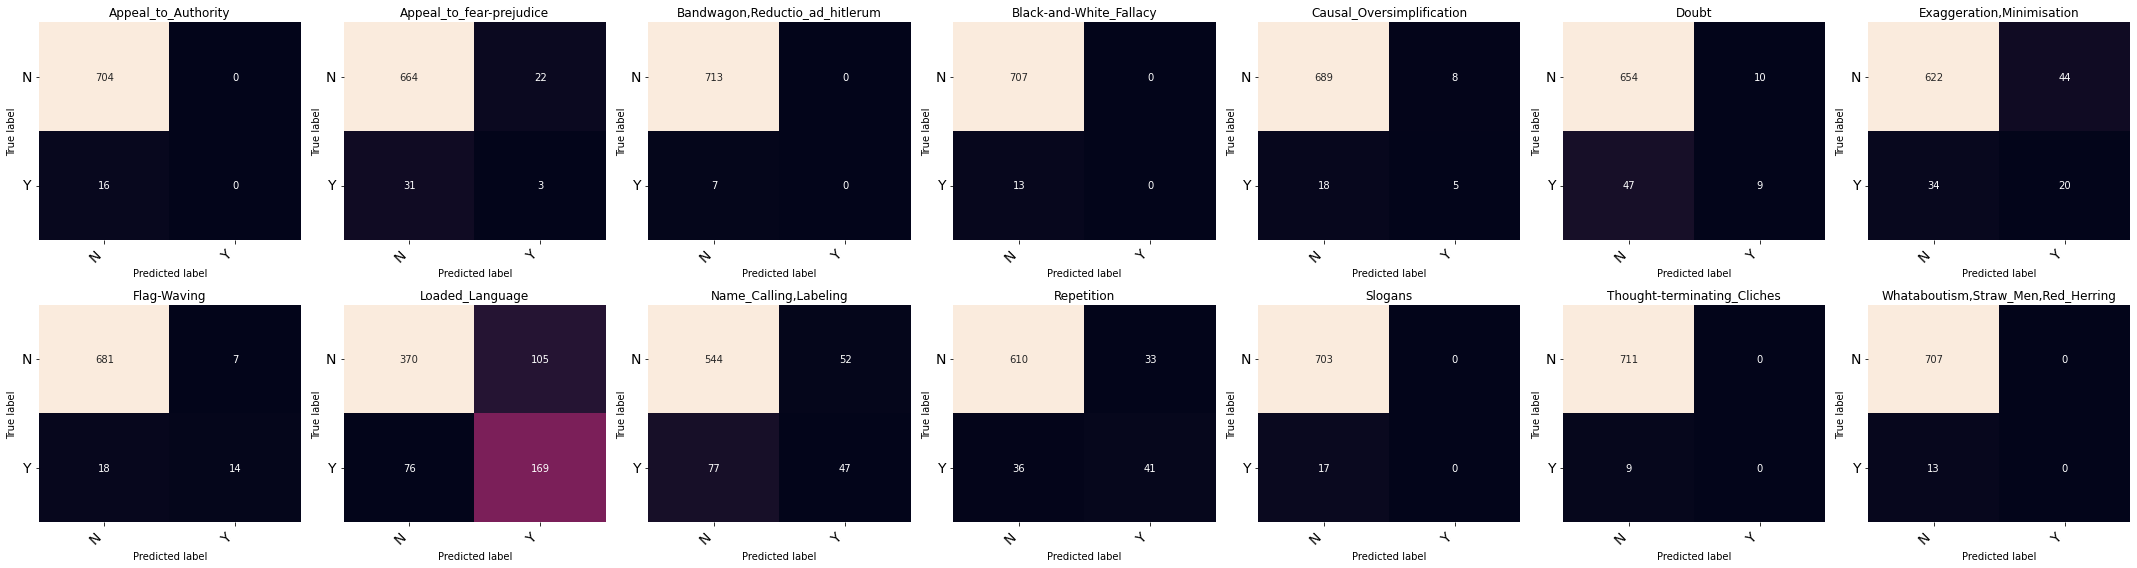

In [22]:
path = "/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Bilstm_model.json"
f = open(path,)
model_args = json.load(f)
f.close()

model = BiLSTM_model(max_features=model_args['max_features'],
                    embedding_dim=model_args['embedding_size'],
                    hidden_dim=model_args['lstm_hidden_dim'],
                    num_layers = model_args['num_lstm_layers'],
                    lstm_dropout = model_args['lstm_dropout'])

model.load_state_dict(torch.load(model_args['model_save_path']))

Test(train, test, model, 'Arabic')